Для задачи анализа ЯМР-данных оптимально подойдет гибридная архитектура, сочетающая сверточные слои для обработки сигналов (FID, CPMG) и полносвязные слои для времени.

Неструктурированные сигналы:

X0; - float[1000] массив спада FID: 1000 точек float;

X1; - float[1000] массив спада CPMG: 2000 точек float;


Структурированные данные:

X2; - float[1] время спин-решеточной релаксации;

==> 1D CNN + FC — оптимальный баланс между точностью и сложностью.

Почему такая архитектура?

Сверточные ветви (FID/CPMG):

Автоматически выделяют локальные паттерны в сигналах.

Max-pooling уменьшает размерность, сохраняя важные признаки.

Обработка X2:

Простой линейный слой, так как это скалярная величина.

Объединяющий классификатор:

Комбинирует признаки из всех источников данных.

Dropout предотвращает переобучение.

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np

In [2]:
class NMRRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Ветвь для FID (1D CNN)
        self.fid_conv = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=5, padding=2),  # [B, 1, 1000] -> [B, 16, 1000]
            nn.ReLU(),
            nn.MaxPool1d(2),                              # -> [B, 16, 500]
            nn.Conv1d(16, 32, kernel_size=5, padding=2),  # -> [B, 32, 500]
            nn.ReLU(),
            nn.MaxPool1d(2),                              # -> [B, 32, 250]
            nn.Flatten()                                   # -> [B, 32*250]
        )
        
        # Ветвь для CPMG (1D CNN)
        self.cpmg_conv = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=5, padding=2),   # [B, 1, 2000] -> [B, 16, 2000]
            nn.ReLU(),
            nn.MaxPool1d(4),                              # -> [B, 16, 500]
            nn.Conv1d(16, 32, kernel_size=5, padding=2),   # -> [B, 32, 500]
            nn.ReLU(),
            nn.MaxPool1d(2),                              # -> [B, 32, 250]
            nn.Flatten()                                   # -> [B, 32*250]
        )
        
        # Ветвь для X2 (простое линейное преобразование)
        self.x2_fc = nn.Linear(1, 32)
        
        # Объединяющий классификатор
        self.final_fc = nn.Sequential(
            nn.Linear(32*250 + 32*250 + 32, 256),  # Сумма выходов всех ветвей
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)  # 2 целевые переменные: Y0, Y1
        )
    
    def forward(self, x_fid, x_cpmg, x2):
        # Обработка FID
        x_fid = x_fid.unsqueeze(1)  # Добавляем размерность канала: [B, 1, 1000]
        fid_features = self.fid_conv(x_fid)
        
        # Обработка CPMG
        x_cpmg = x_cpmg.unsqueeze(1)  # [B, 1, 2000]
        cpmg_features = self.cpmg_conv(x_cpmg)
        
        # Обработка X2
        x2_features = self.x2_fc(x2.unsqueeze(1)).squeeze(1)
        
        # Объединение признаков
        combined = torch.cat([fid_features, cpmg_features, x2_features], dim=1)
        return self.final_fc(combined)

ПОДГОТОВКА ДАННЫХ


Полный формат тензора: [Batch_size, Channels, Sequence_length]

При B=32: [32, 1, 1000] — 32 сигнала FID, каждый из 1000 точек с 1 каналом (моно-сигнал).

In [ ]:
class NMRDataset(Dataset):
    def __init__(self, fid_signals, cpmg_signals, x2, y):
        self.fid = torch.FloatTensor(fid_signals)    # [P, 1000]
        self.cpmg = torch.FloatTensor(cpmg_signals)  # [P, 2000]
        self.x2 = torch.FloatTensor(x2)              # [P]
        self.y = torch.FloatTensor(y)                # [P, 2]
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.fid[idx], self.cpmg[idx], self.x2[idx], self.y[idx]


X0 = np.array([
    [0.12, 0.11, 0.10, ..., 0.01],  # Образец 1 (1000 точек)
    [0.15, 0.14, 0.12, ..., 0.02],
    [0.10, 0.09, 0.08, ..., 0.005]
])
X1 = np.array([
    [0.23, 0.22, 0.20, ..., 0.001],  # Образец 1 (2000 точек)
    [0.25, 0.24, 0.21, ..., 0.002],
    [0.20, 0.18, 0.15, ..., 0.0005]
])
X2 = np.array([1.2, 1.5, 0.8])
Y = np.array([
    [0.75, 0.3],# Образец 1: Y0=75% кристалличность, Y1=30% этиленовых звеньев
    [0.82, 0.2],
    [0.68, 0.4]
])

# X0 = np.random.rand(100, 1000)
# X1 = np.random.rand(100, 2000)
# X2 = np.random.rand(100)
# Y = np.random.rand(100, 2)

dataset = NMRDataset(X0, X1, X2, Y)  # Y.shape = [P, 2]
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

NameError: name 'X0' is not defined

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Используемое устройство:", device)

model = NMRRegressor().to(device)
criterion = nn.MSELoss()  # Для регрессии
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

for epoch in range(100):
    for fid, cpmg, x2, y in dataloader:
        fid, cpmg, x2, y = fid.to(device), cpmg.to(device), x2.to(device), y.to(device)
        
        optimizer.zero_grad()
        outputs = model(fid, cpmg, x2)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Используемое устройство: cpu


NameError: name 'dataloader' is not defined

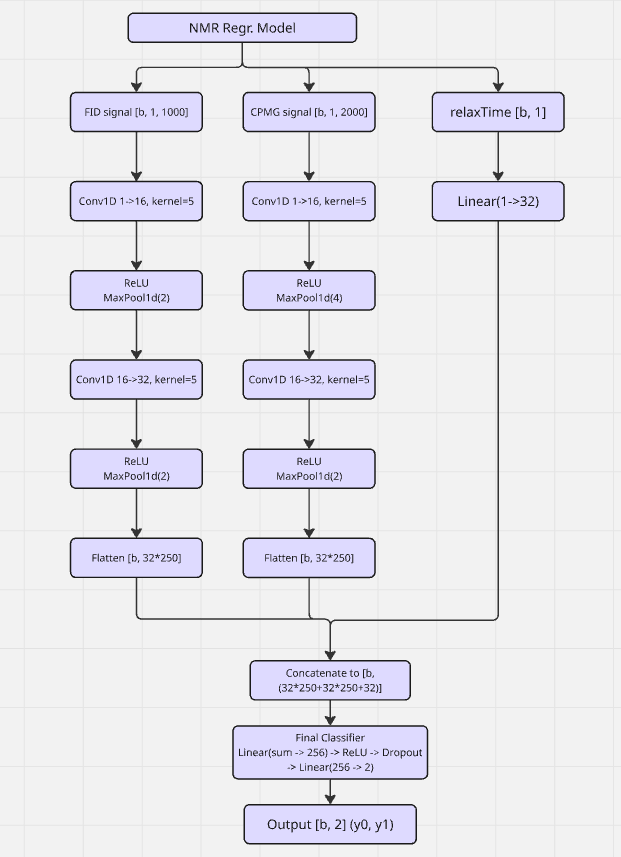